# Implement a neural network for m-samples, n-features as we discussed in class (both FP and BP) and for N layers in the hidden layer. 

# Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data.

# Use 15% for validation  and test your network with the remaining 15% data. 

# Report the evaluation metrics for varying number of layers in the network. 

# Plot the training loss curves.

In [1]:
import numpy as np     # importing different libaries
import math as m
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Defining various functions

In [15]:
def cross_entropy(y, pred_y):
    r, c = np.shape(pred_y)
    error = 0
    if(r == c):
        if(y[0][0] == 1):
            error = -(np.log(pred_y[0][0]))
        else:
            error = -(np.log(1 - pred_y[0][0]))

    else:
        for i in range(r):
            if(y[i][0] == 1):
                error = -np.log(pred_y[i][0])

    return error                                 # returning cost value.


def sigmoid(z, diff):
    val = val = 1/(1 + np.exp(-z))
    if(diff == True):
        val = val*(1 - val)
    return val

def softmax(z, diff):
    r, c = np.shape(z)
    val = np.exp(z)
    denomenator = np.sum(val)
    for i in range(r):
        val[i] = val[i]/denomenator
    return val

def Relu(z, diff):        # defining relu function.
    val = np.maximum(0, z)
    if(diff == True):
        for i in range(val.shape[0]):
            if(z[i] > 0):
                val[i] = 1
            else:
                val[i] = 0
    return val

def Tanh(z, diff):       # defining tanh function.
    val = np.tanh(z)
    if(diff == True):
        val = 1 - val**2
    return val


def grad_J(y, pred_y, pre_activation, activation_function):
    r, c = np.shape(pred_y)
    grad = np.zeros((r, c))

    if(activation_function == softmax):
        one_hot_vector = np.zeros((r, c))
        for i in range(r):
            if(y[i][0] == 1):
                one_hot_vector[i][0] = 1
        grad = -(one_hot_vector - pred_y)

    if(activation_function == sigmoid):
        if(y[0][0] == 1):
            grad[0][0] = -(y[0][0]/pred_y[0][0])
        else:
            grad[0][0] = ((1 - y[0][0])/(1 - pred_y[0][0]))

        grad = grad*(sigmoid(pre_activation, diff = True))

    return grad                                            # returning grad



def forward_prop(x, n_layer, f_list, w_list, b_list):
    layer_output_list = []
    activation_list = []

    h = x
    for i in range(n_layer - 1):
        active = np.dot(w_list[i], h) + b_list[i]
        activation_list.append(active)
        output = f_list[i](active, diff = False)
        layer_output_list.append(output)
        h = output

    active = np.dot(w_list[n_layer - 1], h) + b_list[n_layer - 1]
    activation_list.append(active)
    output = f_list[n_layer - 1](active, diff = False)
    layer_output_list.append(output)

    return activation_list, layer_output_list



def Back_prop(x, y, n_layer, f_list, w_list, b_list, activation_list, layer_output_list):
    grad_b_list = []
    grad_w_list = []

    g = grad_J(y, layer_output_list[n_layer - 1], activation_list[n_layer-1], f_list[n_layer-1])
    #g = g*(f_list[n_layer-1](activation_list[n_layer-1], diff = True))

    for k in range((n_layer-1), -1, -1):
        grad_b = g
        grad_b_list.append(grad_b)

        if(k >= 1):
            grad_w = np.dot(g, layer_output_list[k-1].T)
            grad_w_list.append(grad_w)
        else:
            grad_w = np.dot(g, x.T)
            grad_w_list.append(grad_w)
            break

        g = np.dot(w_list[k].T , g)
        g = g*(f_list[k-1](activation_list[k-1], diff = True))

    grad_b_list = grad_b_list[ : : -1]
    grad_w_list = grad_w_list[ : : -1]

    return  grad_b_list,  grad_w_list


def calculate_error(X, Y, n_layer, f_list, w_list, b_list):
    row, col = np.shape(X)
    err = 0
    for r in range(row):
        x = X[r]
        x = x.reshape((len(x), 1))
        a, b = forward_prop(x, n_layer, f_list, w_list, b_list)
        y = Y[r]
        y = y.reshape((len(y), 1))
        err += cross_entropy(y, b[n_layer - 1])
    err = err/row
    return err


def Gradient_descent(X, Y, X_val, Y_val, n_layer, f_list, w_list, b_list, learning_rate, nEpoch):
    row, col = np.shape(X)
    training_error = []
    validation_error = []
    
        
    for epoch in range(nEpoch):
        err = calculate_error(X, Y, n_layer, f_list, w_list, b_list)
        err1 = calculate_error(X_val, Y_val, n_layer, f_list, w_list, b_list)
        print(f'At {epoch} -th iteration, training error: {err}, validation error :{err1}')
        training_error.append(err)
        validation_error.append(err1)
        
        grad_b_list = []
        grad_w_list = []
        
        for i in range(n_layer):
            mat1 = np.zeros_like(w_list[i], dtype = float)
            grad_w_list.append(mat1)

            mat2 = np.zeros_like(b_list[i], dtype = float)
            grad_b_list.append(mat2)
            
        for j in range(row):
            x = X[j]
            x = x.reshape((len(x), 1))
            y = Y[j]
            y = y.reshape((len(y), 1))

            a, b = forward_prop(x, n_layer, f_list, w_list, b_list)
            c, d = Back_prop(x, y, n_layer, f_list, w_list, b_list, a, b)
            #print('I am in gradient calculation')
            for k in range(n_layer):
                grad_b_list[k] += c[k]
                grad_w_list[k] += d[k]
                
        for m in range(n_layer):
            grad_b_list[m] = grad_b_list[m]/row
            grad_w_list[m] = grad_w_list[m]/row
            
        for n in range(n_layer):
            b_list[n] -= learning_rate*grad_b_list[n]
            w_list[n] -= learning_rate*grad_w_list[n]

    return training_error, validation_error, w_list, b_list


def prediction(y_test, X_test, n_layer, f_list, w_list, b_list):
    y_pred = np.zeros((y_test.shape[0], y_test.shape[1]))
    for j in range(X_test.shape[0]):
        x = X_test[j]
        x = x.reshape((len(x), 1))
        a, b = forward_prop(x, n_layer, f_list, w_list, b_list)
        val = b[n_layer - 1]
        val = val.reshape(1, val.shape[0])
        y_pred[j] = val

    return y_pred

def find_label(y):
    r, c = np.shape(y)
    labeled_y = np.zeros((r, c))
    for i in range(r):
        if(y[i][0] > 0.5):
            labeled_y[i][0] = 1
    return labeled_y


def accu(y, labeled_y):
    count = 0
    for i in range(y.shape[0]):
        if((y[i] == labeled_y[i]).all()):
            count += 1

    accuracy = count/y.shape[0]
    return accuracy

def evaluation_metric(y, y_pred_label):     # evaluation metric 
    eps = 10e-7
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(y.shape[0]):
        if((y[i][0] == 1) and (y_pred_label[i][0] == 1)):
            TP += 1
        if((y[i][0] == 0) and (y_pred_label[i][0] == 0)):
            TN += 1    
        if((y[i][0] == 0) and (y_pred_label[i][0] == 1)):
            FP += 1
        if((y[i][0] == 1) and (y_pred_label[i][0] == 0)):  
            FN += 1
    print(f'True positive: {TP}, True negetive: {TN}, False positive: {FP}, False negetive: {FN}')
    P = TP/(TP+FP+eps)
    R = TP/(TP+FN+eps)
    print('The precision is:', P)
    print('The recall is:', R)

    F1 = 2*((P*R)/(P+R+eps))
    print('The f1 score is:', F1)

    Acc = (TP + TN)/(TP + FP + FN + TN)
    print('The accuracy is:', Acc)


def parameter_initialization(x, layer_sizes):
    length = len(x)
    np.random.seed(1)
    w_list1 = [np.random.randn(layer_sizes[0], length)]
    w_list2 = [np.random.randn(next_layer, prev_layer) for prev_layer, next_layer in zip(layer_sizes[:-1], layer_sizes[1:])]
    w_list = w_list1 + w_list2

    b_list = [np.random.randn(layer, 1) for layer in layer_sizes]
    return w_list, b_list



# Extracting data from csv file.

In [40]:
data = pd.read_csv('Logistic_regression_ls.csv')    # reads the smarket csv file using pandas library.

# print('The given data-set is:')
# print(data)

# extracting the ground truth label column from the data set.
y = data[['label']]
y = y.values

# extracting the features from the adta set.
features = data[data.columns[0 : (len(data.columns)-1)]]
features = features.values

r, c = np.shape(features)

for i in range(c):     # normalizing the features.
    features[:,i] = (features[:,i] - features[:,i].mean())/features[:,i].std()
    

X = features

#print('--------------------------The design matrix is :-------------------------------')
#print(X)

r, c = np.shape(X)
print(f'The shape of design matrix is: {r} {c}')


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

r1, c1 = np.shape(X_train)
print(f'The shape of x_train set is: {r1} {c1}')
    
r2, c2 = np.shape(y_train)
print(f'The shape of y_train set is: {r2} {c2}')

r3, c3 = np.shape(X_val)
print(f'The shape of x_validation set is: {r3} {c3}')

r4, c4 = np.shape(y_val)
print(f'The shape of y_validation set is: {r4} {c4}')

r5, c5 = np.shape(X_test)
print(f'The shape of x_test set is: {r5} {c5}')

r6, c6 = np.shape(y_test)
print(f'The shape of y_test set is: {r6} {c6}')



The shape of design matrix is: 500 2
The shape of x_train set is: 350 2
The shape of y_train set is: 350 1
The shape of x_validation set is: 75 2
The shape of y_validation set is: 75 1
The shape of x_test set is: 75 2
The shape of y_test set is: 75 1


# The number of layer is two. The activation function in the hidden layers is ReLU and output layer is sigmoid.

In [35]:
n_layer = 2
layer_sizes = [5, 1]
w_list, b_list = parameter_initialization(X_train[0], layer_sizes)
f_list = [Relu, sigmoid]

tr_err, val_err, list_w, list_b = Gradient_descent(X_train, y_train, X_val, y_val,
                                                   n_layer, f_list, w_list, b_list, learning_rate = 0.01, nEpoch = 100)



At 0 -th iteration, training error: 0.5265326251603307, validation error :0.5287217903687758
At 1 -th iteration, training error: 0.5202399086621526, validation error :0.5219125928312361
At 2 -th iteration, training error: 0.5140325046066784, validation error :0.5152048302732729
At 3 -th iteration, training error: 0.5079277085819672, validation error :0.5086147928638964
At 4 -th iteration, training error: 0.5019167994027594, validation error :0.5021402523017255
At 5 -th iteration, training error: 0.4959822620671135, validation error :0.4957585304297553
At 6 -th iteration, training error: 0.49014446963645913, validation error :0.4894894026984135
At 7 -th iteration, training error: 0.4843703430085001, validation error :0.48331487993573774
At 8 -th iteration, training error: 0.47867941820227145, validation error :0.4771987337700516
At 9 -th iteration, training error: 0.473083111112161, validation error :0.4711916969007598
At 10 -th iteration, training error: 0.46757967686165414, validation

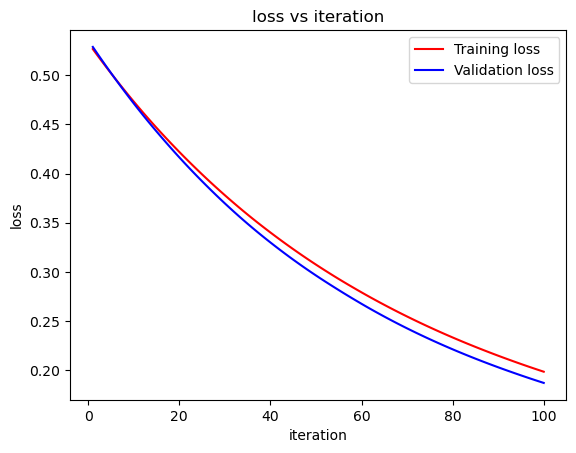

In [36]:
n_iteration1 = len(tr_err)  # array of costs at each iteration
n_iteration1 = list(range(1, n_iteration1+1))

plt.plot(n_iteration1, tr_err, color = 'red', label = 'Training loss')
plt.plot(n_iteration1, val_err, color = 'blue', label = 'Validation loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration')
plt.legend(loc = 'upper right')
plt.show()


In [37]:
print(f'The training error is: {tr_err[len(tr_err)-1]}')
print(f'The validation error is: {val_err[len(val_err)-1]}')

test_error1 = calculate_error(X_test, y_test, n_layer, f_list, list_w, list_b)
print(f'The test error is: {test_error1}')



The training error is: 0.19853921818248121
The validation error is: 0.18714236826432976
The test error is: 0.1696577593453595


In [38]:
y_train_pred = prediction(y_train, X_train, n_layer, f_list, list_w, list_b)
labeled_y_train = find_label(y_train_pred)
train_accuracy1 = accu(y_train, labeled_y_train)
print(f'The train accuracy is: {train_accuracy1}')

y_val_pred = prediction(y_val, X_val, n_layer, f_list, list_w, list_b)
labeled_y_val = find_label(y_val_pred)
validation_accuracy1 = accu(y_val, labeled_y_val)
print(f'The validation accuracy is: {validation_accuracy1}')

y_test_pred = prediction(y_test, X_test, n_layer, f_list, list_w, list_b)
labeled_y_test = find_label(y_test_pred)
test_accuracy1 = accu(y_test, labeled_y_test)
print(f'The test accuracy is: {test_accuracy1}')


The train accuracy is: 1.0
The validation accuracy is: 1.0
The test accuracy is: 1.0


In [39]:
print('-----------------:The evaluation metric for train set:-----------------------')
evaluation_metric(y_train, labeled_y_train)

print('-----------------:The evaluation metric for validation set:-----------------------')
evaluation_metric(y_val, labeled_y_val)

print('-----------------:The evaluation metric for test set:-----------------------')
evaluation_metric(y_test, labeled_y_test)


-----------------:The evaluation metric for train set:-----------------------
True positive: 181, True negetive: 169, False positive: 0, False negetive: 0
The precision is: 0.9999999944751382
The recall is: 0.9999999944751382
The f1 score is: 0.9999994944753883
The accuracy is: 1.0
-----------------:The evaluation metric for validation set:-----------------------
True positive: 39, True negetive: 36, False positive: 0, False negetive: 0
The precision is: 0.999999974358975
The recall is: 0.999999974358975
The f1 score is: 0.9999994743592251
The accuracy is: 1.0
-----------------:The evaluation metric for test set:-----------------------
True positive: 30, True negetive: 45, False positive: 0, False negetive: 0
The precision is: 0.9999999666666678
The recall is: 0.9999999666666678
The f1 score is: 0.9999994666669179
The accuracy is: 1.0


# The number of layer is three. The activation function in two hidden layers is ReLU and output layer is sigmoid.

In [56]:
n_layer = 3
layer_sizes = [5, 3, 1]
w_list, b_list = parameter_initialization(X_train[0], layer_sizes)
f_list = [Relu, Relu, sigmoid]

tr_err, val_err, list_w, list_b = Gradient_descent(X_train, y_train, X_val, y_val,
                                                   n_layer, f_list, w_list, b_list, learning_rate = 0.01, nEpoch = 400)




At 0 -th iteration, training error: 0.818714980359718, validation error :0.8184504835764087
At 1 -th iteration, training error: 0.8152681556085559, validation error :0.8145072430883189
At 2 -th iteration, training error: 0.8118992211840079, validation error :0.8106265192886634
At 3 -th iteration, training error: 0.8086089827388573, validation error :0.8068390425271125
At 4 -th iteration, training error: 0.8053754597377536, validation error :0.8032007518150086
At 5 -th iteration, training error: 0.8021684292392828, validation error :0.7996153661843256
At 6 -th iteration, training error: 0.798987425414182, validation error :0.7960608071245683
At 7 -th iteration, training error: 0.7958412122869345, validation error :0.7925365145285147
At 8 -th iteration, training error: 0.7927719897365283, validation error :0.7890806391885299
At 9 -th iteration, training error: 0.7897432793570907, validation error :0.7856531482170154
At 10 -th iteration, training error: 0.7867692710702897, validation erro

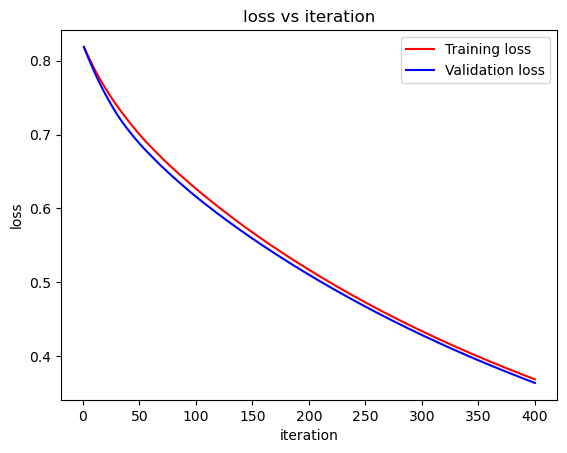

In [57]:
n_iteration1 = len(tr_err)  # array of costs at each iteration
n_iteration1 = list(range(1, n_iteration1+1))

plt.plot(n_iteration1, tr_err, color = 'red', label = 'Training loss')
plt.plot(n_iteration1, val_err, color = 'blue', label = 'Validation loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration')
plt.legend(loc = 'upper right')
plt.show()


In [58]:
print(f'The training error is: {tr_err[len(tr_err)-1]}')
print(f'The validation error is: {val_err[len(val_err)-1]}')

test_error1 = calculate_error(X_test, y_test, n_layer, f_list, list_w, list_b)
print(f'The validation error is: {test_error1}')



The training error is: 0.36826360605510455
The validation error is: 0.36331285465104396
The validation error is: 0.29779174025039656


In [59]:
y_train_pred = prediction(y_train, X_train, n_layer, f_list, list_w, list_b)
labeled_y_train = find_label(y_train_pred)
train_accuracy1 = accu(y_train, labeled_y_train)
print(f'The train accuracy is: {train_accuracy1}')

y_val_pred = prediction(y_val, X_val, n_layer, f_list, list_w, list_b)
labeled_y_val = find_label(y_val_pred)
validation_accuracy1 = accu(y_val, labeled_y_val)
print(f'The validation accuracy is: {validation_accuracy1}')

y_test_pred = prediction(y_test, X_test, n_layer, f_list, list_w, list_b)
labeled_y_test = find_label(y_test_pred)
test_accuracy1 = accu(y_test, labeled_y_test)
print(f'The test accuracy is: {test_accuracy1}')



The train accuracy is: 0.9885714285714285
The validation accuracy is: 1.0
The test accuracy is: 1.0


In [60]:
print('-----------------:The evaluation metric for train set:-----------------------')
evaluation_metric(y_train, labeled_y_train)

print('-----------------:The evaluation metric for validation set:-----------------------')
evaluation_metric(y_val, labeled_y_val)

print('-----------------:The evaluation metric for test set:-----------------------')
evaluation_metric(y_test, labeled_y_test)


-----------------:The evaluation metric for train set:-----------------------
True positive: 177, True negetive: 169, False positive: 0, False negetive: 4
The precision is: 0.9999999943502825
The recall is: 0.9779005470834224
The f1 score is: 0.9888263101809589
The accuracy is: 0.9885714285714285
-----------------:The evaluation metric for validation set:-----------------------
True positive: 39, True negetive: 36, False positive: 0, False negetive: 0
The precision is: 0.999999974358975
The recall is: 0.999999974358975
The f1 score is: 0.9999994743592251
The accuracy is: 1.0
-----------------:The evaluation metric for test set:-----------------------
True positive: 30, True negetive: 45, False positive: 0, False negetive: 0
The precision is: 0.9999999666666678
The recall is: 0.9999999666666678
The f1 score is: 0.9999994666669179
The accuracy is: 1.0


# The number of layer is four. The activation function in three hidden layers is ReLU and output layer is sigmoid.

In [66]:
n_layer = 4
layer_sizes = [5, 4, 3, 1]
w_list, b_list = parameter_initialization(X_train[0], layer_sizes)
f_list = [Relu, Relu, Relu, sigmoid]


tr_err, val_err, list_w, list_b = Gradient_descent(X_train, y_train, X_val, y_val,
                                                   n_layer, f_list, w_list, b_list, learning_rate = 0.01, nEpoch = 500)




At 0 -th iteration, training error: 0.7594662012319956, validation error :0.7594691925315021
At 1 -th iteration, training error: 0.7581214571354588, validation error :0.758196975351028
At 2 -th iteration, training error: 0.7567833153731413, validation error :0.7569318981212793
At 3 -th iteration, training error: 0.755451117869006, validation error :0.755673086200338
At 4 -th iteration, training error: 0.7541276357758193, validation error :0.7544208162829062
At 5 -th iteration, training error: 0.7528125030143192, validation error :0.753174702517035
At 6 -th iteration, training error: 0.7515052795669279, validation error :0.7519346067111403
At 7 -th iteration, training error: 0.7501997863904101, validation error :0.7506992396564593
At 8 -th iteration, training error: 0.7489035725118999, validation error :0.7494693984480514
At 9 -th iteration, training error: 0.7476159794889888, validation error :0.7482452130444289
At 10 -th iteration, training error: 0.746325061362286, validation error :

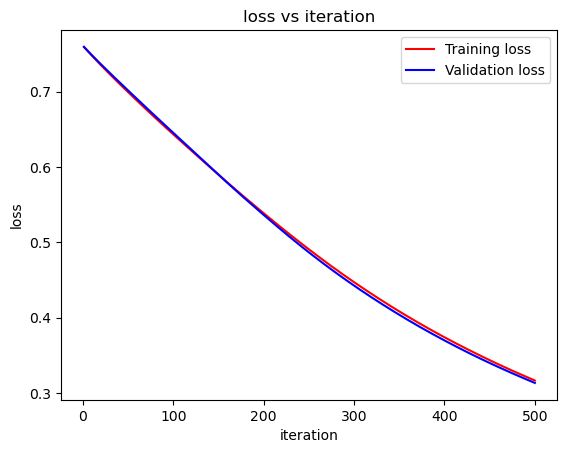

In [67]:
n_iteration1 = len(tr_err)  # array of costs at each iteration
n_iteration1 = list(range(1, n_iteration1+1))

plt.plot(n_iteration1, tr_err, color = 'red', label = 'Training loss')
plt.plot(n_iteration1, val_err, color = 'blue', label = 'Validation loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss vs iteration')
plt.legend(loc = 'upper right')
plt.show()


In [68]:
print(f'The training error is: {tr_err[len(tr_err)-1]}')
print(f'The validation error is: {val_err[len(val_err) - 1]}')

test_error1 = calculate_error(X_test, y_test, n_layer, f_list, list_w, list_b)
print(f'The validation error is: {test_error1}')



The training error is: 0.31667821992932027
The validation error is: 0.31345595695184975
The validation error is: 0.404808002249224


In [69]:
y_train_pred = prediction(y_train, X_train, n_layer, f_list, list_w, list_b)
labeled_y_train = find_label(y_train_pred)
train_accuracy1 = accu(y_train, labeled_y_train)
print(f'The train accuracy is: {train_accuracy1}')

y_val_pred = prediction(y_val, X_val, n_layer, f_list, list_w, list_b)
labeled_y_val = find_label(y_val_pred)
validation_accuracy1 = accu(y_val, labeled_y_val)
print(f'The validation accuracy is: {validation_accuracy1}')

y_test_pred = prediction(y_test, X_test, n_layer, f_list, list_w, list_b)
labeled_y_test = find_label(y_test_pred)
test_accuracy1 = accu(y_test, labeled_y_test)
print(f'The test accuracy is: {test_accuracy1}')


The train accuracy is: 0.9914285714285714
The validation accuracy is: 1.0
The test accuracy is: 0.96


In [70]:
print('-----------------:The evaluation metric for train set:-----------------------')
evaluation_metric(y_train, labeled_y_train)

print('-----------------:The evaluation metric for validation set:-----------------------')
evaluation_metric(y_val, labeled_y_val)

print('-----------------:The evaluation metric for test set:-----------------------')
evaluation_metric(y_test, labeled_y_test)


-----------------:The evaluation metric for train set:-----------------------
True positive: 181, True negetive: 166, False positive: 3, False negetive: 0
The precision is: 0.983695646827741
The recall is: 0.9999999944751382
The f1 score is: 0.9917803165174223
The accuracy is: 0.9914285714285714
-----------------:The evaluation metric for validation set:-----------------------
True positive: 39, True negetive: 36, False positive: 0, False negetive: 0
The precision is: 0.999999974358975
The recall is: 0.999999974358975
The f1 score is: 0.9999994743592251
The accuracy is: 1.0
-----------------:The evaluation metric for test set:-----------------------
True positive: 30, True negetive: 42, False positive: 3, False negetive: 0
The precision is: 0.9090908815427007
The recall is: 0.9999999666666678
The f1 score is: 0.9523804232806856
The accuracy is: 0.96
